In [0]:
#Install PySpark
!pip install -q pyspark
!pip install --quiet numpy
!pip install -q scikit-learn-extra

You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-023efd1b-754c-4eca-9421-d01799ec8786/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-023efd1b-754c-4eca-9421-d01799ec8786/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-023efd1b-754c-4eca-9421-d01799ec8786/bin/python -m pip install --upgrade pip' command.


# Distributed K-Means Algorithm Using Spark

In [0]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import FloatType,ArrayType,IntegerType
from pyspark.sql.functions import to_timestamp
from pyspark.sql.functions import trim
import seaborn
import random
import sys
import numpy as np
import matplotlib.pyplot as plt

# Initialize Spark session
spark = SparkSession.builder.appName("DistributedKMeans").getOrCreate()

input = "dbfs:/FileStore/tables/Online_Retail_small.csv"
Online_Retailsdf = spark.read.option("header", "true").option("inferSchema", "true").option("sep", ",").csv( input )
Online_Retailsdf = Online_Retailsdf.limit(10000)
Online_Retailsdf =  Online_Retailsdf.withColumn("Monetary Value",F.col('Quantity')*F.col('UnitPrice'))
Online_Retailsdf = Online_Retailsdf.withColumn("InvoiceNo", F.col("InvoiceNo").cast(FloatType()))
Online_Retailsdf = Online_Retailsdf.filter((F.col("Monetary Value") < sys.float_info.max) & (~F.isnan("Monetary Value")))
Online_Retailsdf =  Online_Retailsdf.withColumn("InvoiceDate",trim(Online_Retailsdf["InvoiceDate"]))
Online_Retailsdf =  Online_Retailsdf.withColumn("InvoiceDate",to_timestamp( Online_Retailsdf["InvoiceDate"], 
"dd-MM-yyyy HH:mm"))
Online_Retailsdf = Online_Retailsdf.filter((F.col("InvoiceNo").isNotNull() ) & (~F.isnan("InvoiceNo")))

### Removing Outliers Using Z-Score

In [0]:
# Calculate the Z-score for each column (Quantity and UnitPrice)
def calculate_zscore(df, column_name):
    mean_value = df.agg(F.mean(column_name).alias('mean')).collect()[0]['mean']
    stddev_value = df.agg(F.stddev(column_name).alias('stddev')).collect()[0]['stddev']
    zscore_column = (F.col(column_name) - mean_value) / stddev_value
    return zscore_column

# Calculate Z-scores for Quantity and UnitPrice columns
Online_Retailsdf = Online_Retailsdf.withColumn('InvoiceNo_zscore', calculate_zscore(Online_Retailsdf, 'InvoiceNo'))
Online_Retailsdf = Online_Retailsdf.withColumn('Monetary_Value_zscore', calculate_zscore(Online_Retailsdf, 'Monetary Value'))

# Filter out rows where Z-score is greater than the threshold (e.g., |Z| > 3)
threshold = 3
Online_Retailsdf_filtered = Online_Retailsdf.filter(
    (F.abs(Online_Retailsdf['InvoiceNo_zscore']) <= threshold) &
    (F.abs(Online_Retailsdf['Monetary_Value_zscore']) <= threshold)
)

# Show the filtered DataFrame


# Optional: Drop the Z-score columns if no longer needed
Online_Retailsdf_filtered = Online_Retailsdf_filtered.drop('InvoiceNo_zscore', 'Monetary_Value_zscore')
Online_Retailsdf = Online_Retailsdf_filtered
# Online_Retailsdf_filtered.show()

In [0]:
# Function to compute the Euclidean distance between two points
def compute_distance(point1, point2, metric="euclidean"):
    """Compute distance between two points."""
    if metric == "euclidean":
        return float(np.sqrt(np.sum((np.array(point1) - np.array(point2)) ** 2)))
    elif metric == "manhattan":
        return float(np.sum(np.abs(np.array(point1) - np.array(point2))))
    else:
        raise ValueError("Unsupported distance metric: {}".format(metric))

# UDF for assigning clusters based on nearest medoid
def assign_cluster(point, centroids, metric="euclidean"):
    distances = [compute_distance(point, centroid, metric) for centroid in centroids]
    return int(distances.index(min(distances)))

# Register UDF for cluster assignment
assign_cluster_udf = F.udf(lambda point: assign_cluster(point, centroids, "euclidean"), IntegerType())

# Function to compute the cost (sum of squared distances)
def compute_cost(data, centroids):
    total_cost = 0
    # Assign each point to the nearest medoid and calculate the total distance
    for point in data.collect():
        point_features = point['features']
        cluster_id = assign_cluster(point_features, centroids)
        centroid = centroids[cluster_id]
        total_cost += compute_distance(point_features, centroid)**2
    return total_cost

# Convert columns to a feature vector in a list
feature_columns = ['InvoiceNo', 'Monetary Value']
Online_Retailsdf = Online_Retailsdf.withColumn("features", F.array(*[F.col(c).cast(FloatType()) for c in feature_columns]))

# Initialize parameters
k = 10  # Number of clusters
max_iterations = 2

cost = 0

costs = []
k_range = np.arange(1,k+1,1)
# Randomly initialize centroids by sampling `k` points from the dataset
centroids = Online_Retailsdf.orderBy(F.rand()).limit(k).select("features").rdd.flatMap(lambda x: x).collect()

for i in range(1,k+1):
    # Iteratively update centroids
    centroids = Online_Retailsdf.orderBy(F.rand()).limit(k).select("features").rdd.flatMap(lambda x: x).collect()
    
    for iteration in range(max_iterations):
        clustered_data = Online_Retailsdf.withColumn("cluster", assign_cluster_udf(F.struct("features")))

        # Step 2: Recalculate centroids by averaging the points in each cluster
        new_centroids = []
        for cluster_id in range(i):
            # Select points in the current cluster and calculate the average for each feature
            cluster_points = clustered_data.filter(F.col("cluster") == cluster_id)
            if cluster_points.count() > 0:
                new_centroid = cluster_points.select(
                    *[F.avg(F.col("features")[i]).alias(f"features_{i}") for i in range(len(feature_columns))]
                ).collect()[0]
                new_centroids.append([new_centroid[f"features_{i}"] for i in range(len(feature_columns))])
            else:
                # If a cluster is empty, retain the previous centroid
                new_centroids.append(centroids[cluster_id])

        # Check for convergence by comparing old and new centroids
        converged = all(compute_distance(new_centroids[l], centroids[l]) < 1e-2 for l in range(i))
        centroids = new_centroids
        cost = compute_cost(Online_Retailsdf, centroids)
        if converged:
            print(f"Converged after {iteration + 1} iterations for k = {i}.")
            break
          # Squared Euclidean distance
    costs.append(cost)

Converged after 2 iterations for k = 1.
Converged after 2 iterations for k = 2.
Converged after 2 iterations for k = 3.
Converged after 2 iterations for k = 4.
Converged after 2 iterations for k = 5.
Converged after 2 iterations for k = 6.
Converged after 2 iterations for k = 7.
Converged after 2 iterations for k = 8.
Converged after 2 iterations for k = 9.
Converged after 2 iterations for k = 10.


### Plots and Results

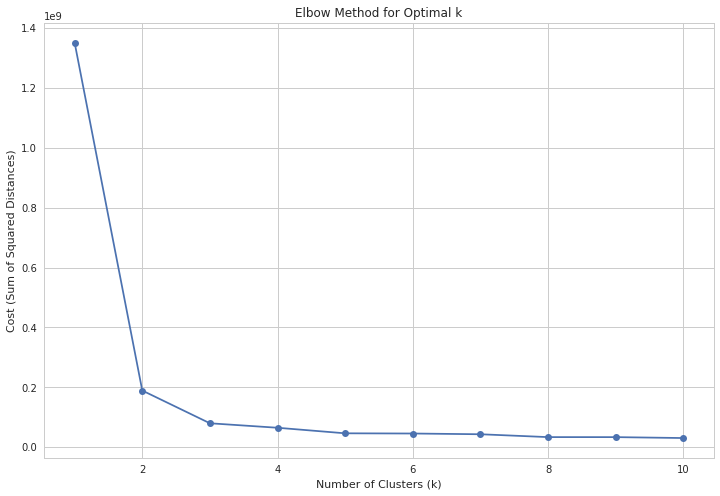

Final Cluster Centers:
Cluster 1: [536545.2971285892, 9.287453183669426]
Cluster 2: [537099.2082982899, 13.179142140773187]
Cluster 3: [536740.1081081082, 10.212594592893446]
Cluster 4: [536443.4669966997, 14.016617181572583]
Cluster 5: [536802.6413662239, 27.11943081977019]
Cluster 6: [536549.7487437186, 73.88753786518346]
Cluster 7: [536684.6878980892, 23.38076434317668]
Cluster 8: [536866.4446085672, 11.878862600272832]
Cluster 9: [536758.5, 12.415730330548929]
Cluster 10: [536603.4982674982, 11.454358965075851]
+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+------------------+-----------------+-------+
|InvoiceNo|StockCode|         Description|Quantity|        InvoiceDate|UnitPrice|CustomerID|       Country|    Monetary Value|         features|cluster|
+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+------------------+-----------------+-------+
| 536365.0|   85123A

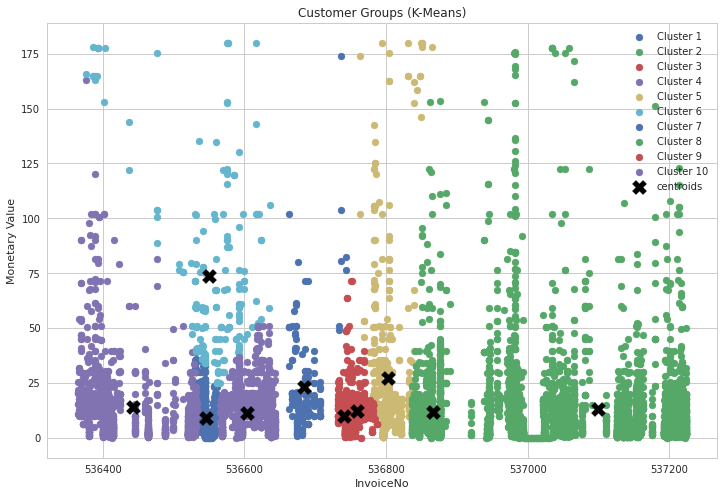

In [0]:
# Plot Elbow Method to find optimal 
plt.figure(figsize=(12, 8))
plt.plot(k_range, costs, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Cost (Sum of Squared Distances)')
plt.grid(True)
plt.show()

    # Show final centroids
print("Final Cluster Centers:")
for idx, centroid in enumerate(centroids):
    print(f"Cluster {idx + 1}: {centroid}")

def get_centroid(cluster_id):
    # Return the corresponding centroid for the given cluster_id
    return centroids[int(cluster_id)]  # Convert numpy array to list for UDF compatibility

# Register UDF with correct return type (ArrayType(FloatType()))
get_centroid_udf = F.udf(get_centroid, ArrayType(FloatType()))


clustered_data.show()
#final_clustered_data = Online_Retailsdf.withColumn("cluster", assign_cluster_udf(F.struct("features")))

# Add a new column 'Centroids' to the dataframe based on the 'prediction' column (cluster label)
final_clustered_data = clustered_data.withColumn('Centroids', get_centroid_udf(F.col('cluster')))

# Show predictions with features, cluster labels, and centroids
final_clustered_data.select("features", "cluster", "Centroids").show(20)


final_clustered_data_pd = final_clustered_data.toPandas()

# Extract the features and cluster assignments
X = np.array(final_clustered_data_pd['features'].to_list())  # Convert list of features to a numpy array
labels = final_clustered_data_pd['cluster'].values

# Convert the medoids into a NumPy array for plotting
centroids_np = np.array(centroids)
print(centroids_np)
# Plot each cluster with a distinct color
plt.figure(figsize=(12, 8))

for i in range(k):
    plt.scatter(X[labels == i, 0], X[labels == i, 1], label=f'Cluster {i+1}')

# Highlight the medoids
plt.scatter(centroids_np[:, 0], centroids_np[:, 1], s=200, c='black', marker='X', label='centroids')

# Title and labels for the plot
plt.title('Customer Groups (K-Means)')
plt.xlabel('InvoiceNo')
plt.ylabel('Monetary Value')
plt.legend()
plt.grid(True)
plt.show()
# # Stop Spark session
# spark.stop()

# Distributed K - Means Algorithm using MLib library

In [0]:
from pyspark.sql import SparkSession
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import col
import matplotlib.pyplot as plt
import numpy as np
from pyspark.sql import functions as F
from pyspark.sql.types import FloatType,ArrayType
from pyspark.sql.functions import to_timestamp
from pyspark.sql.functions import trim
import seaborn
import random

# Initialize Spark session
spark = SparkSession.builder.appName("DistributedKMeans").getOrCreate()

input = "dbfs:/FileStore/tables/Online_Retail_small.csv"
Online_Retailsdf = spark.read.option("header", "true").option("inferSchema", "true").option("sep", ",").csv( input )
Online_Retailsdf = Online_Retailsdf.limit(1000)
Online_Retailsdf =  Online_Retailsdf.withColumn("Monetary Value",F.col('Quantity')*F.col('UnitPrice'))
Online_Retailsdf = Online_Retailsdf.withColumn("InvoiceNo", F.col("InvoiceNo").cast(FloatType()))
Online_Retailsdf = Online_Retailsdf.filter((F.col("Monetary Value") < sys.float_info.max) & (~F.isnan("Monetary Value")))
Online_Retailsdf =  Online_Retailsdf.withColumn("InvoiceDate",trim(Online_Retailsdf["InvoiceDate"]))
Online_Retailsdf =  Online_Retailsdf.withColumn("InvoiceDate",to_timestamp( Online_Retailsdf["InvoiceDate"], 
"dd-MM-yyyy HH:mm"))
Online_Retailsdf = Online_Retailsdf.filter((F.col("InvoiceNo").isNotNull() ) & (~F.isnan("InvoiceNo")))

data = Online_Retailsdf
# Display the first few rows of the dataset
# data.show()

# Select the relevant features for clustering

# Convert columns to a feature vector in a list
feature_columns = ['InvoiceNo', 'Monetary Value']
Online_Retailsdf = Online_Retailsdf.withColumn("features", F.array(*[F.col(c).cast(FloatType()) for c in feature_columns]))
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Transform the data to have a single "features" column
dataset = assembler.transform(data).select("features")

### Removing Outliers Using Z-Score

In [0]:
# Calculate the Z-score for each column (Quantity and UnitPrice)
def calculate_zscore(df, column_name):
    mean_value = df.agg(F.mean(column_name).alias('mean')).collect()[0]['mean']
    stddev_value = df.agg(F.stddev(column_name).alias('stddev')).collect()[0]['stddev']
    zscore_column = (F.col(column_name) - mean_value) / stddev_value
    return zscore_column

# Calculate Z-scores for Quantity and UnitPrice columns
Online_Retailsdf = Online_Retailsdf.withColumn('InvoiceNo_zscore', calculate_zscore(Online_Retailsdf, 'InvoiceNo'))
Online_Retailsdf = Online_Retailsdf.withColumn('Monetary_Value_zscore', calculate_zscore(Online_Retailsdf, 'Monetary Value'))

# Filter out rows where Z-score is greater than the threshold (e.g., |Z| > 3)
threshold = 3
Online_Retailsdf_filtered = Online_Retailsdf.filter(
    (F.abs(Online_Retailsdf['InvoiceNo_zscore']) <= threshold) &
    (F.abs(Online_Retailsdf['Monetary_Value_zscore']) <= threshold)
)

# Show the filtered DataFrame


# Optional: Drop the Z-score columns if no longer needed
Online_Retailsdf_filtered = Online_Retailsdf_filtered.drop('InvoiceNo_zscore', 'Monetary_Value_zscore')
Online_Retailsdf = Online_Retailsdf_filtered
# Online_Retailsdf_filtered.show()

In [0]:
# Elbow Method: Calculate cost (sum of squared distances) for different k values
max_k = 10 # Set k to the number of clusters you want
max_iterations = 100
costs = []
k_range = range(2, max_k+1)  # Trying k from 1 to 10
for k_val in k_range:
    kmeans = KMeans().setK(k_val).setMaxIter(1).setSeed(1)
    model = kmeans.fit(dataset)
    
    # Calculate cost manually by summing squared distances from points to centroids
    predictions = model.transform(dataset)
    cost = 0.0
    for row in predictions.collect():
        point = np.array(row['features'])
        cluster_id = row['prediction']
        centroid = np.array(model.clusterCenters()[cluster_id])
        cost += np.sum((point - centroid) ** 2)  # Squared Euclidean distance
    costs.append(cost)
    print('Converged for k = ' + str(k_val))

# Let's assume optimal k is 3 based on the elbow plot (you can adjust this after inspection)
optimal_k = 10

# Fit K-Means model with the optimal number of clusters
kmeans = KMeans().setK(optimal_k).setMaxIter(1).setSeed(1)
model = kmeans.fit(dataset)

# Make predictions
predictions = model.transform(dataset)
centroids = model.clusterCenters()

# Function to map the cluster label to the corresponding centroid
def get_centroid(cluster_id):
    return centroids[cluster_id].tolist()  # Convert numpy array to list for UDF compatibility

# Register UDF with correct return type (ArrayType(FloatType()))
get_centroid_udf = F.udf(get_centroid, ArrayType(FloatType()))

# Add centroids to the predictions
predictions_with_centroids = predictions.withColumn('Centroids', get_centroid_udf(F.col('prediction')))



Converged for k = 2
Converged for k = 3
Converged for k = 4
Converged for k = 5
Converged for k = 6
Converged for k = 7
Converged for k = 8
Converged for k = 9
Converged for k = 10


### Plots and Results

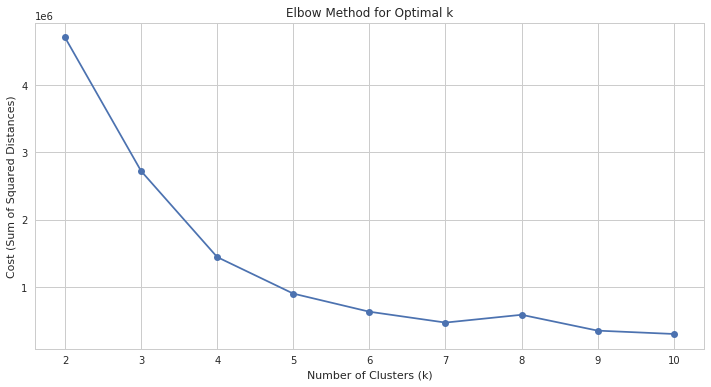

/databricks/spark/python/pyspark/sql/pandas/conversion.py:122: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unable to convert the field features. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: Unsupported type in conversion to Arrow: VectorUDT()
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


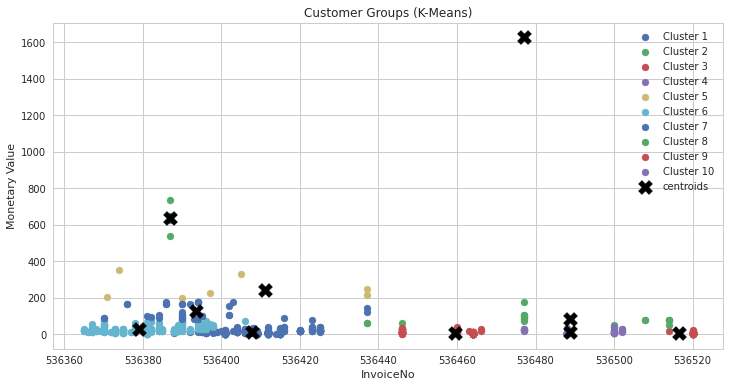

[[5.36407829e+05 1.14218354e+01]
 [5.36387000e+05 6.38784000e+02]
 [5.36516441e+05 5.55838235e+00]
 [5.36477000e+05 1.62720000e+03]
 [5.36411000e+05 2.41660000e+02]
 [5.36379054e+05 2.49533498e+01]
 [5.36393556e+05 1.25572500e+02]
 [5.36488833e+05 8.24800000e+01]
 [5.36459402e+05 7.37515152e+00]
 [5.36488667e+05 1.19537255e+01]]
+--------------------+----------+--------------------+
|            features|prediction|           Centroids|
+--------------------+----------+--------------------+
|[536365.0,15.2999...|         5|[536379.06, 24.95...|
|    [536365.0,20.34]|         5|[536379.06, 24.95...|
|     [536365.0,22.0]|         5|[536379.06, 24.95...|
|    [536365.0,20.34]|         5|[536379.06, 24.95...|
|    [536365.0,20.34]|         5|[536379.06, 24.95...|
|     [536365.0,15.3]|         5|[536379.06, 24.95...|
|     [536365.0,25.5]|         5|[536379.06, 24.95...|
|[536366.0,11.1000...|         5|[536379.06, 24.95...|
|[536366.0,11.1000...|         5|[536379.06, 24.95...|
|    [536

In [0]:
# Plot Elbow Method to find optimal k
plt.figure(figsize=(12, 6))
plt.plot(k_range, costs, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Cost (Sum of Squared Distances)')
plt.show()

# Plotting the clustered data with the centroids highlighted
final_clustered_data_pd = predictions_with_centroids.toPandas()
# Extract the features and cluster assignments
X = np.array(final_clustered_data_pd['features'].to_list())  # Convert list of features to a numpy array
labels = final_clustered_data_pd['prediction'].values

# Convert the medoids into a NumPy array for plotting
centroids_np = np.array(centroids)
# Plot each cluster with a distinct color
plt.figure(figsize=(12, 6))

for i in range(k):
    plt.scatter(X[labels == i, 0], X[labels == i, 1], label=f'Cluster {i+1}')

# Highlight the medoids
plt.scatter(
    centroids_np[:, 0], 
    centroids_np[:, 1], 
    s=200, 
    c='black', 
    marker='X', 
    label='centroids'
)

# Title and labels for the plot
plt.title('Customer Groups (K-Means)')
plt.xlabel('InvoiceNo')
plt.ylabel('Monetary Value')
plt.legend()
plt.show()

print(centroids_np)
predictions_with_centroids.show()


# Distributed K-Medoid Clustering Using Spark

In [0]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import FloatType,ArrayType
from pyspark.sql.functions import to_timestamp
from pyspark.sql.functions import trim
import random
import sys
import matplotlib.pyplot as plt
import numpy as np

# Initialize Spark session
spark = SparkSession.builder.appName("DistributedKMedoid").getOrCreate()

input = "dbfs:/FileStore/tables/Online_Retail_small.csv"
Online_Retailsdf = spark.read.option("header", "true").option("inferSchema", "true").option("sep", ",").csv( input )
Online_Retailsdf = Online_Retailsdf.limit(10000)
Online_Retailsdf =  Online_Retailsdf.withColumn("Monetary Value",F.col('Quantity')*F.col('UnitPrice'))
Online_Retailsdf = Online_Retailsdf.withColumn("InvoiceNo", F.col("InvoiceNo").cast(FloatType()))
Online_Retailsdf = Online_Retailsdf.filter((F.col("Monetary Value") < sys.float_info.max) & (~F.isnan("Monetary Value")))
Online_Retailsdf =  Online_Retailsdf.withColumn("InvoiceDate",trim(Online_Retailsdf["InvoiceDate"]))
Online_Retailsdf =  Online_Retailsdf.withColumn("InvoiceDate",to_timestamp( Online_Retailsdf["InvoiceDate"], "dd-MM-yyyy HH:mm"))
Online_Retailsdf = Online_Retailsdf.filter((F.col("InvoiceNo").isNotNull() ) & (~F.isnan("InvoiceNo")))


### Removing Outliers using Z-score

In [0]:
# Calculate the Z-score for each column (Quantity and UnitPrice)
def calculate_zscore(df, column_name):
    mean_value = df.agg(F.mean(column_name).alias('mean')).collect()[0]['mean']
    stddev_value = df.agg(F.stddev(column_name).alias('stddev')).collect()[0]['stddev']
    zscore_column = (F.col(column_name) - mean_value) / stddev_value
    return zscore_column

# Calculate Z-scores for Quantity and UnitPrice columns
Online_Retailsdf = Online_Retailsdf.withColumn('InvoiceNo_zscore', calculate_zscore(Online_Retailsdf, 'InvoiceNo'))
Online_Retailsdf = Online_Retailsdf.withColumn('Monetary_Value_zscore', calculate_zscore(Online_Retailsdf, 'Monetary Value'))

# Filter out rows where Z-score is greater than the threshold (e.g., |Z| > 3)
threshold = 3
Online_Retailsdf_filtered = Online_Retailsdf.filter(
    (F.abs(Online_Retailsdf['InvoiceNo_zscore']) <= threshold) &
    (F.abs(Online_Retailsdf['Monetary_Value_zscore']) <= threshold)
)
# Show the filtered DataFrame


# Optional: Drop the Z-score columns if no longer needed
Online_Retailsdf_filtered = Online_Retailsdf_filtered.drop('InvoiceNo_zscore', 'Monetary_Value_zscore')
Online_Retailsdf = Online_Retailsdf_filtered
# Online_Retailsdf_filtered.show()

In [0]:
# Function to compute the Euclidean distance between two points
def compute_distance(point1, point2, metric="euclidean"):
    """Compute distance between two points."""
    if metric == "euclidean":
        return float(np.sqrt(np.sum((np.array(point1) - np.array(point2)) ** 2)))
    elif metric == "manhattan":
        return float(np.sum(np.abs(np.array(point1) - np.array(point2))))
    else:
        raise ValueError("Unsupported distance metric: {}".format(metric))

# UDF for assigning clusters based on nearest medoid
def assign_cluster(point, medoids, metric="euclidean"):
    distances = [compute_distance(point, medoid, metric) for medoid in medoids]
    return int(distances.index(min(distances)))

# Register UDF for cluster assignment
assign_cluster_udf = F.udf(lambda point: assign_cluster(point, medoids, "euclidean"), IntegerType())

# Function to compute the cost (sum of squared distances)
def compute_cost(data, medoids):
    total_cost = 0
    # Assign each point to the nearest medoid and calculate the total distance
    for point in data.collect():
        point_features = point['features']
        cluster_id = assign_cluster(point_features, medoids)
        medoid = medoids[cluster_id]
        total_cost += compute_distance(point_features, medoid)
    return total_cost

feature_columns = ['InvoiceNo','Monetary Value']
Online_Retailsdf = Online_Retailsdf.withColumn("features", F.array(*[F.col(c).cast(FloatType()) for c in feature_columns]))

# List to store costs for different values of k
cost = 0
costs = []
iterations = 100
k = 10
data = Online_Retailsdf


# Iterate over different values of k
for i in range(1, k+1):
    # Initialize medoids randomly for each k
    medoids = data.orderBy(F.rand()).limit(k).select("features").rdd.flatMap(lambda x: x).collect()
    # Run the K-Medoids algorithm for the current value of k (same as the above distributed code)
    for iteration in range(iterations):  # Set max_iterations here
        clustered_data = data.withColumn("cluster", assign_cluster_udf(F.col("features")))

        new_medoids = []
        for cluster_id in range(i):
            cluster_points = clustered_data.filter(F.col("cluster") == cluster_id).select("features").collect()
            if len(cluster_points) > 0:
                min_total_distance = float("inf")
                best_medoid = None
                for candidate in cluster_points:
                    candidate_point = candidate["features"]
                    total_distance = sum(
                        compute_distance(candidate_point, other["features"]) for other in cluster_points
                    )
                    if total_distance < min_total_distance:
                        min_total_distance = total_distance
                        best_medoid = candidate_point
                new_medoids.append(best_medoid)
            else:
                new_medoids.append(medoids[cluster_id])
        medoids = new_medoids
        cost = compute_cost(data, medoids)
        # Check for convergence
        if all(compute_distance(new_medoids[l], medoids[l]) < 1e-4 for l in range(i)):
            print(f"Converged after {iteration + 1} iterations for k = {i}.")
            break
        
    
    # Compute the cost for the current clustering
        
    costs.append(cost)

# Final cluster assignment
final_clustered_data = data.withColumn("cluster", assign_cluster_udf(F.col("features")))
final_clustered_data.show()



Converged after 1 iterations for k = 1.
Converged after 1 iterations for k = 2.
Converged after 1 iterations for k = 3.
Converged after 1 iterations for k = 4.
Converged after 1 iterations for k = 5.
Converged after 1 iterations for k = 6.
Converged after 1 iterations for k = 7.
Converged after 1 iterations for k = 8.
Converged after 1 iterations for k = 9.
Converged after 1 iterations for k = 10.
+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+------------------+-----------------+-------+
|InvoiceNo|StockCode|         Description|Quantity|        InvoiceDate|UnitPrice|CustomerID|       Country|    Monetary Value|         features|cluster|
+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+------------------+-----------------+-------+
| 536365.0|   85123A|WHITE HANGING HEA...|       6|2010-12-01 08:26:00|     2.55|     17850|United Kingdom|15.299999999999999| [536365.0, 15

### Plots and Results

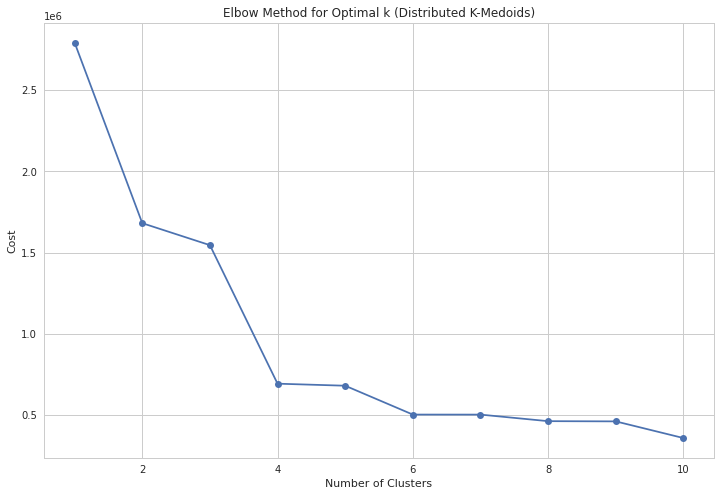

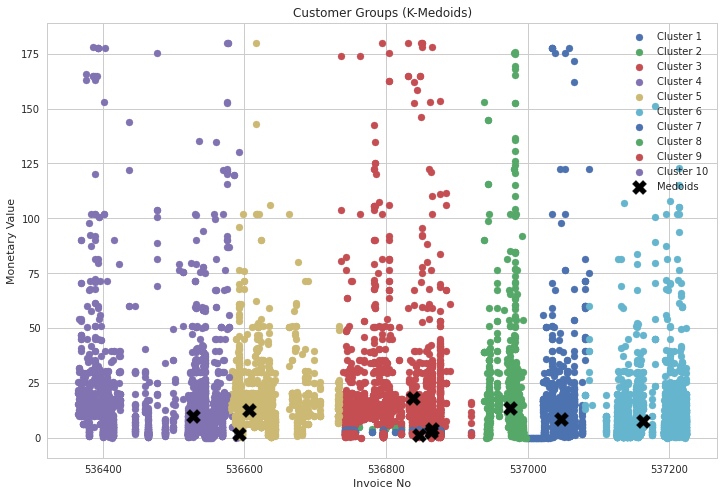

In [0]:
# Plotting the elbow graph
plt.figure(figsize=(12, 8))
plt.plot(range(1, k+1), costs, marker='o')
plt.title('Elbow Method for Optimal k (Distributed K-Medoids)')
plt.xlabel('Number of Clusters')
plt.ylabel('Cost')
plt.show()


# Convert the Spark DataFrame to Pandas DataFrame for plotting
final_clustered_data_pd = final_clustered_data.toPandas()

# Extract the features and cluster assignments
X = np.array(final_clustered_data_pd['features'].to_list())  # Convert list of features to a numpy array
labels = final_clustered_data_pd['cluster'].values

# Convert the medoids into a NumPy array for plotting
medoids_np = np.array(medoids)

# Plot each cluster with a distinct color
plt.figure(figsize=(12, 8))

for i in range(k):
    plt.scatter(X[labels == i, 0], X[labels == i, 1], label=f'Cluster {i+1}')

# Highlight the medoids
plt.scatter(
    medoids_np[:, 0], 
    medoids_np[:, 1], 
    s=200, 
    c='black', 
    marker='X', 
    label='Medoids'
)
# Title and labels for the plot
plt.title('Customer Groups (K-Medoids)')
plt.xlabel('Invoice No')
plt.ylabel('Monetary Value')
plt.legend()
plt.show()

# Non Distributed K-Medoid Clustering Using sklearn_extra.cluster library

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn_extra.cluster import KMedoids

# loading the data from csv file to a Pandas DataFrame
customer_data = Online_Retailsdf.toPandas()

# selecting the features for clustering
X = customer_data.iloc[:, [0, 8]].values  # InvoiceNo and Monetary Value
max_k = 10
# Remove rows where any feature is NaN or infinity
X_cleaned = X[~np.isnan(X).any(axis=1)]  # Remove rows with NaN values
X_cleaned = X_cleaned[~np.isinf(X_cleaned).any(axis=1)]  # Remove rows with infinity values

# finding the cost (similar to WCSS in K-Means) for different numbers of clusters
costs = []
for i in range(1, max_k+1):
    kmedoids = KMedoids(n_clusters=i, random_state=42, metric="euclidean")
    kmedoids.fit(X_cleaned)
    costs.append(kmedoids.inertia_)


/local_disk0/.ephemeral_nfs/envs/pythonEnv-023efd1b-754c-4eca-9421-d01799ec8786/lib/python3.9/site-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 2 is empty! self.labels_[self.medoid_indices_[2]] may not be labeled with its corresponding cluster (2).
  warnings.warn(
/local_disk0/.ephemeral_nfs/envs/pythonEnv-023efd1b-754c-4eca-9421-d01799ec8786/lib/python3.9/site-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 2 is empty! self.labels_[self.medoid_indices_[2]] may not be labeled with its corresponding cluster (2).
  warnings.warn(
/local_disk0/.ephemeral_nfs/envs/pythonEnv-023efd1b-754c-4eca-9421-d01799ec8786/lib/python3.9/site-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 3 is empty! self.labels_[self.medoid_indices_[3]] may not be labeled with its corresponding cluster (3).
  warnings.warn(
/local_disk0/.ephemeral_nfs/envs/pythonEnv-023efd1b-754c-4eca-9421-d01799ec8786/lib/python3.9/site-packages/sklearn_extra/cl

### Plots and Results

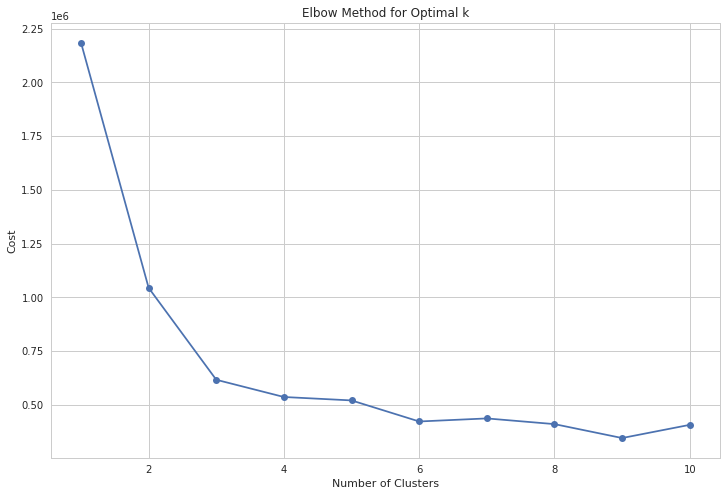

/local_disk0/.ephemeral_nfs/envs/pythonEnv-023efd1b-754c-4eca-9421-d01799ec8786/lib/python3.9/site-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 1 is empty! self.labels_[self.medoid_indices_[1]] may not be labeled with its corresponding cluster (1).
  warnings.warn(
/local_disk0/.ephemeral_nfs/envs/pythonEnv-023efd1b-754c-4eca-9421-d01799ec8786/lib/python3.9/site-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 3 is empty! self.labels_[self.medoid_indices_[3]] may not be labeled with its corresponding cluster (3).
  warnings.warn(
/local_disk0/.ephemeral_nfs/envs/pythonEnv-023efd1b-754c-4eca-9421-d01799ec8786/lib/python3.9/site-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 5 is empty! self.labels_[self.medoid_indices_[5]] may not be labeled with its corresponding cluster (5).
  warnings.warn(


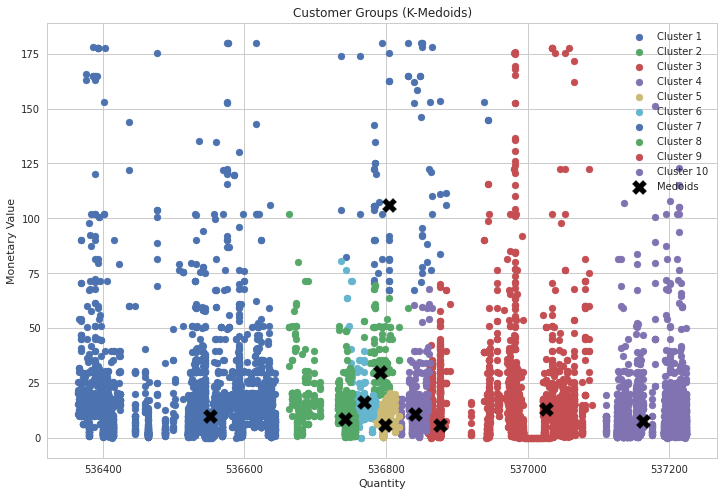

In [0]:
# Plotting the elbow graph to find the optimal number of clusters
plt.figure(figsize=(12, 8))
plt.plot(range(1, 11), costs, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('Cost')
plt.show()

# Applying K-Medoids with the optimal number of clusters
optimal_k = 10  # Based on the elbow graph
kmedoids = KMedoids(n_clusters=optimal_k, random_state=42, metric="euclidean")
labels = kmedoids.fit_predict(X_cleaned)

# Plotting the clusters and medoids
plt.figure(figsize=(12, 8))

# Plot each cluster with a distinct color
for i in range(optimal_k):
    plt.scatter(X_cleaned[labels == i, 0], X_cleaned[labels == i, 1], label=f'Cluster {i+1}')

# Highlight the medoids
plt.scatter(
    kmedoids.cluster_centers_[:, 0],
    kmedoids.cluster_centers_[:, 1],
    s=200,
    c='black',
    marker='X',
    label='Medoids',
)

plt.title('Customer Groups (K-Medoids)')
plt.xlabel('Quantity')
plt.ylabel('Monetary Value')
plt.legend()
plt.show()
